In [64]:
# Core libraries
import os, sys, random
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# HF tokenizer only (no Trainer here)
from transformers import AutoTokenizer

# Sk-learn metrics for confusion matrix later
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

In [65]:
# --------------------------------------------------
#  Project-specific paths and helper modules
# --------------------------------------------------
project_dir = Path().resolve().parent          # <repo_root>/
src_dir     = project_dir / "src"
sys.path.append(str(src_dir))

try:
    from paths import DATA_CLEANED, DATA_PROCESSED
except ModuleNotFoundError:
    DATA_CLEANED   = project_dir / "data" / "cleaned"
    DATA_PROCESSED = project_dir / "data" / "processed"

# helper_functions & models from your repo
from helper_functions import (
    HateSpeechDataset,
    train_model,
    test_model,
    get_class_distribution,
    oversample_dataset,
    undersample_dataset
)
from models import BaseCNNClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [66]:
model_name = "xlnet-base-cased"
tokenizer   = AutoTokenizer.from_pretrained(model_name)

label_col = "task_1"

# cleaned TSV files
train_path = DATA_CLEANED / "hasoc_2019_en_train_cleaned.tsv"
test_path  = DATA_CLEANED / "hasoc_2019_en_test_cleaned.tsv"

df_train_full = pd.read_csv(train_path, sep="\t")
df_test       = pd.read_csv(test_path,  sep="\t")

# stratified split 70 / 30
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(
    df_train_full,
    test_size=0.30,
    random_state=42,
    stratify=df_train_full[label_col]
)

# map HOF / NOT → 1 / 0
label_list = sorted(train_df[label_col].unique())
label_map  = {lab: idx for idx, lab in enumerate(label_list)}
for split in (train_df, val_df, df_test):
    split[label_col] = split[label_col].map(label_map)

print("Class distribution:", get_class_distribution(train_df, label_col))


Class distribution: {1: 2513, 0: 1583}


In [67]:
imbalance_mode = "class_weighting"   # options: 'class_weighting', 'oversampling', 'undersampling'

if imbalance_mode == "oversampling":
    train_df = oversample_dataset(train_df, label_col)
elif imbalance_mode == "undersampling":
    train_df = undersample_dataset(train_df, label_col)


In [68]:
train_ds = HateSpeechDataset(train_df, tokenizer, label=label_col)
val_ds   = HateSpeechDataset(val_df,   tokenizer, label=label_col)
test_ds  = HateSpeechDataset(df_test,  tokenizer, label=label_col)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16)
test_loader  = DataLoader(test_ds,  batch_size=32)


In [69]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df[label_col]),
    y=train_df[label_col]
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


In [72]:
# Number of Transformer layers to unfreeze (identical to your old run)
unfreeze_last_layers = 2   
    
# BaseCNNClassifier takes FOUR positional arguments:
#   (model_name, class_weights_tensor, device, unfreeze_last_layers)
model = BaseCNNClassifier(
    model_name,
    class_weights_tensor,
    device,
    unfreeze_last_layers          # ← positional, not a keyword
).to(device)



Epoch 1
Training Loss: 0.5768
Train Accuracy: 0.6895
Train F1 (macro): 0.6767

Val Loss: 0.6592
Val Accuracy: 0.6606
Val F1 (macro): 0.6446

New best model saved (F1: 0.6446, Acc: 0.6606)

Epoch 2
Training Loss: 0.5662
Train Accuracy: 0.7063
Train F1 (macro): 0.6896

Val Loss: 0.6615
Val Accuracy: 0.6617
Val F1 (macro): 0.6422


Epoch 3
Training Loss: 0.5738
Train Accuracy: 0.6948
Train F1 (macro): 0.6771

Val Loss: 0.6647
Val Accuracy: 0.6606
Val F1 (macro): 0.6396


Epoch 4
Training Loss: 0.5679
Train Accuracy: 0.6956
Train F1 (macro): 0.6763

Val Loss: 0.6680
Val Accuracy: 0.6617
Val F1 (macro): 0.6406


Epoch 5
Training Loss: 0.5642
Train Accuracy: 0.7068
Train F1 (macro): 0.6869

Val Loss: 0.6719
Val Accuracy: 0.6623
Val F1 (macro): 0.6423


Epoch 6
Training Loss: 0.5567
Train Accuracy: 0.7097
Train F1 (macro): 0.6922

Val Loss: 0.6739
Val Accuracy: 0.6617
Val F1 (macro): 0.6424


Epoch 7
Training Loss: 0.5628
Train Accuracy: 0.7021
Train F1 (macro): 0.6846

Val Loss: 0.6759
Val 

current_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_f1_macro,▁
test_f1_weighted,▁
test_loss,▁
test_precision_macro,▁
test_recall_macro,▁
train_accuracy,▁▅▂▂▅▆▄▅▅▄▃█▆▅▅▄▅▇▅▆
train_f1_macro,▁▅▁▁▄▅▃▄▄▃▂█▆▅▅▃▅▇▅▅
train_f1_weighted,▁▅▂▂▅▆▄▄▅▄▃█▆▅▅▄▅▇▅▅


Final test metrics: {'f1': 0.6512377442458799, 'accuracy': 0.6981786643538594}


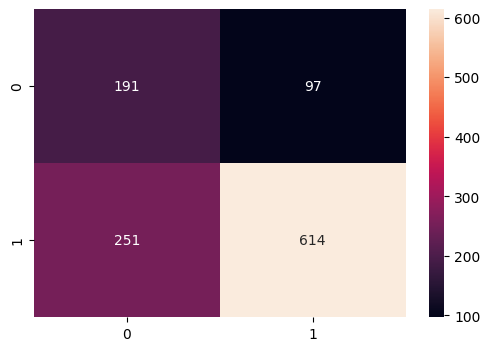

In [79]:
import wandb

learning_rate = 0.00002                          # same LR you used before
epochs        = 20

# Optimizer on the classifier head (exactly as earlier)
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=learning_rate)

# ── Weights & Biases run ──────────────────────────────────────────
wandb.init(
    project = "xlnet-hate-speech",
    config  = dict(
        model_name      = model_name,
        unfrozen_layers = unfreeze_last_layers,
        epochs          = epochs,
        lr              = learning_rate,
        imbalance_mode  = imbalance_mode
    )
)

# train_model signature:
# train_model(model, train_loader, test_loader, optimizer, device, epochs, best_model_path, scheduler=False)

train_model(
    model,
    train_loader,      # training batches
    val_loader,        # validation batches inside the helper act as "test_loader"
    optimizer,
    device,
    epochs,
    "best_xlnet.pt"    # checkpoint file
)

# Load the best checkpoint
model.load_state_dict(torch.load("best_xlnet.pt", weights_only=True))

# Final evaluation on the held-out test set
test_metrics = test_model(model, test_loader, device, phase="test")
print("Final test metrics:", test_metrics)

# ── CLOSE the W&B run ────────────────────────────────────────────────
import wandb
wandb.finish()          # <— this line explicitly ends the run